#### AQI Predictor Prototype
##### **Goal**: Predict the next 24 hour AQI, based on the past 12-hour data (30 mins-interval) 
##### **Last Updated**: 17/06/2025
- Bahy Helmi Hartoyo Putra
- bahyhelmi97@gmail.com


#### Training Pipeline

In [22]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import joblib
import matplotlib.pyplot as plt

In [38]:
# 2. Load Data
df = pd.read_csv("input.csv", parse_dates=['timestamp'])
df = df.sort_values("timestamp")

# For prototype, we'll use: Subset last X days
x_days = 2
df = df[df['timestamp'] >= df['timestamp'].max() - pd.Timedelta(days=x_days)]
print(df.shape)
df.head(2)

(97, 37)


,created_at,updated_at,id,timestamp,PM25,PM10,O3,SO2,NO,NO2,...,AQI,AQI_detail,AQI_parameter,PM25_AQI,PM10_AQI,O3_AQI,SO2_AQI,NO2_AQI,CO_AQI,CH4_AQI
6691,2025-05-24 11:53:53.958527+00,2025-05-29 09:23:37.76187+00,13559,2025-05-22 18:30:00+00:00,17.0167,28.0616,18.6344,6.9171,2.2333,35.3888,...,78,"{""CO"": 21, ""O3"": 11, ""CH4"": 4, ""NO2"": 29, ""SO2...",PM25,78,40,11,9,29,21,4
6692,2025-05-24 11:53:53.961339+00,2025-05-29 09:30:38.84316+00,13560,2025-05-22 19:00:00+00:00,26.7487,40.9343,21.5069,6.9354,1.0469,25.4352,...,77,"{""CO"": 21, ""O3"": 11, ""CH4"": 4, ""NO2"": 28, ""SO2...",PM25,77,40,11,9,28,21,4


In [31]:
# 3. Feature Selection
features = ['PM25', 'PM10', 'O3', 'SO2', 'NO', 'NO2', 'NOX', 'CO', 'CH4',
            'NMHC', 'THC', 'wind_speed', 'wind_gust_speed',
            'wind_direction', 'air_humidity', 'air_temperature',
            'container_humidity', 'container_temperature', 'solar_radiation']
target = 'AQI'

In [32]:
# 4. Framing the problem as Supervised Learning
input_len = 24   # past 12 hours (30min × 24 = 12hr)
output_len = 48  # next 24 hours (30min × 48 = 24hr)

X, y = [], []
for i in range(input_len, len(df) - output_len):
    X.append(df[features].iloc[i - input_len:i].values.flatten())
    y.append(df[target].iloc[i:i + output_len].values)

X = np.array(X)
y = np.array(y)

In [33]:
X.shape, y.shape

((25, 456), (25, 48))

In [34]:
# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [35]:
# 6. Normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
# 7. Model Training
# Caution: Might takes time! Please be patient, monitor your CPU & Memory usage.
base_model = GradientBoostingRegressor()
model = MultiOutputRegressor(base_model)
model.fit(X_train_scaled, y_train)

MultiOutputRegressor(estimator=GradientBoostingRegressor())

In [37]:
# 8. Save Model
joblib.dump(model, 'aqi_forecast_model.pkl')
joblib.dump(scaler, 'aqi_scaler.pkl')

['aqi_scaler.pkl']

#### Inference Pipeline

In [45]:
X_test_scaled.shape

(5, 456)

In [39]:
# 9. Inference
y_pred = model.predict(X_test_scaled)
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))

Mean Absolute Error (MAE): 2.427852716662926


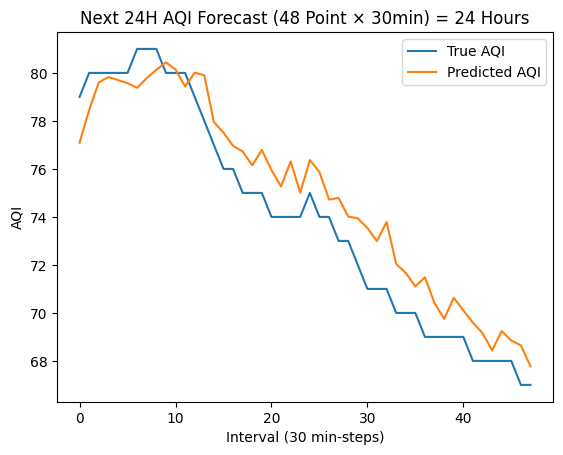

In [47]:
# 10. Visualization Example of the first 24 hours rolling window
plt.plot(y_test[0], label='True AQI')
plt.plot(y_pred[0], label='Predicted AQI')
plt.title('Next 24H AQI Forecast (48 Point × 30min) = 24 Hours')
plt.legend()

plt.xlabel("Interval (30 min-steps)")
plt.ylabel("AQI")
plt.show()

#### API Inference

In [48]:
import requests

In [67]:
# Taking last 12 hours data until 2025-05-23, 06.00 AM
test_data = df.head(24)
test_data.tail()['timestamp']

6710   2025-05-23 04:00:00+00:00
6711   2025-05-23 04:30:00+00:00
6712   2025-05-23 05:00:00+00:00
6713   2025-05-23 05:30:00+00:00
6714   2025-05-23 06:00:00+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

In [68]:
# Create test data, drop all unnecessary features & target (AQI)
test_data_filtered = test_data[features+['timestamp']]
test_data_filtered.tail()

,PM25,PM10,O3,SO2,NO,NO2,NOX,CO,CH4,NMHC,THC,wind_speed,wind_gust_speed,wind_direction,air_humidity,air_temperature,container_humidity,container_temperature,solar_radiation,timestamp
6710,55.0600,55.6248,10.0082,6.6068,0.5094,13.9536,7.6750,387.2453,2.2948,0.3079,2.6035,0.8444,2.74,254.4333,97.0295,24.9551,28.1124,27.8351,0.2930,2025-05-23 04:00:00+00:00
6711,41.3033,55.4662,10.1767,6.7736,0.5458,15.1040,8.3033,346.1927,2.2730,0.2971,2.5707,0.7641,2.42,226.9425,96.4427,24.9511,27.1383,27.7342,0.2955,2025-05-23 04:30:00+00:00
6712,67.2918,61.0223,10.0151,7.3573,0.3823,13.8384,7.5133,401.0773,2.2878,0.3564,2.6446,0.7296,2.54,247.9116,96.1247,24.9637,27.8969,28.0405,0.2354,2025-05-23 05:00:00+00:00
6713,71.5250,51.0275,10.0773,7.6935,0.4198,12.4560,6.8233,382.3307,2.2947,0.2561,2.5505,0.7343,3.03,265.0283,95.6054,24.9153,28.3050,27.9257,0.2652,2025-05-23 05:30:00+00:00
6714,63.6993,55.8476,6.4324,7.9348,0.7063,14.9328,8.3425,463.2707,2.5365,0.3289,2.8644,0.4522,1.92,260.8912,95.6233,24.9090,27.8386,27.8395,0.6172,2025-05-23 06:00:00+00:00


In [69]:
# Save the dummy data
test_data_filtered.to_csv("recent_data.csv")

In [86]:
# Get the predicted result for the next 24 hours
files = {'file': open('recent_data.csv', 'rb')}
res = requests.post("http://localhost:8080/predict", files=files)
print(res.json())

{'predicted_AQI_next_24h': [79.9999428929924, 79.99994156492244, 80.99991500352354, 80.99991367545361, 79.99993890878257, 78.99996547018145, 77.99999335965026, 76.0000504666579, 76.0000571070076, 76.00006374735733, 76.00006905963711, 76.00007437191688, 77.00005312279778, 77.00005577893765, 77.0000571070076, 77.0000571070076, 77.00005577893765, 77.00005445086771, 78.00002523332894, 78.00002124911911, 78.9999907035104, 79.99995750176178, 79.9999495333421, 79.99994156492244, 79.99993359650279, 79.99992695615306, 80.99989242633451, 80.9998831298449, 80.9998634175688, 79.99988844212467, 79.99987200386921, 79.99984041440045, 78.99986015980943, 77.99987204600822, 76.99991234738366, 75.99992961229295, 75.99992164387328, 74.99993890878257, 74.99993094036289, 74.99992297194323, 73.99994156492244, 73.99993492457273, 73.99992695615306, 73.99991898773337, 74.99988445791485, 73.99990172282412, 73.99989375440445, 72.99991101931373], 'step': 'Each step = 30 minutes', 'unit': 'AQI'}


In [87]:
# Cross check with real data in the next 24 hours
df.iloc[24:48]['AQI']

6715    80
6716    80
6717    81
6718    81
6719    80
6720    79
6721    78
6722    76
6723    76
6724    76
6725    76
6726    76
6727    77
6728    77
6729    77
6730    77
6731    77
6732    77
6733    78
6734    78
6735    79
6736    80
6737    80
6738    80
Name: AQI, dtype: int64

#### Summary
- In this prototype, for the sake of efficiency & proof-of-concept, we only use the most recent **2 days** of data during the **training**.
- We could always increase the time window to (possibly) get more (seasonal/monthly) context.
- Accuracy is not bad, as visualize on the above graph!